# Data: Lake Michigan Waves

https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku

Predict wave height based on wave period

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("~/datasets/Beach_Water_Quality_-_Automated_Sensors.csv")
df.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
0,Calumet Beach,04/07/2018 12:30:00 AM,21.7,3.15,NaN,0.389,3.0,0.0,04/07/2018 12:30 AM,CalumetBeach201804072430
1,Ohio Street Beach,06/14/2019 07:00:00 PM,16.0,2.18,NaN,0.137,3.0,11.8,06/14/2019 7:00 PM,OhioStreetBeach201906141900
2,Ohio Street Beach,05/16/2018 01:00:00 PM,21.7,1.92,NaN,0.023,1.0,10.3,05/16/2018 1:00 PM,OhioStreetBeach201805161300
3,Ohio Street Beach,05/16/2018 02:00:00 PM,21.9,1.81,NaN,0.026,6.0,10.3,05/16/2018 2:00 PM,OhioStreetBeach201805161400
4,Ohio Street Beach,06/04/2018 09:00:00 AM,23.0,0.03,NaN,0.021,8.0,12.4,06/04/2018 9:00 AM,OhioStreetBeach201806040900


<AxesSubplot:xlabel='Wave Period', ylabel='Wave Height'>

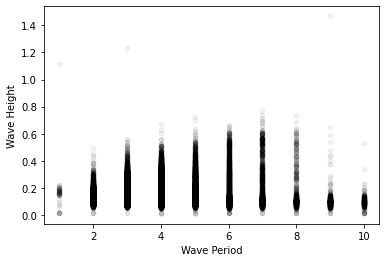

In [8]:
df = df[(df["Wave Period"] > 0) & (df["Wave Height"] > 0)]
df.plot.scatter(x="Wave Period", y="Wave Height", color="k", alpha=0.05)

In [12]:
beach_names = sorted(set(df["Beach Name"]))
beach_names

['63rd Street Beach',
 'Calumet Beach',
 'Montrose Beach',
 'Ohio Street Beach',
 'Osterman Beach',
 'Rainbow Beach']

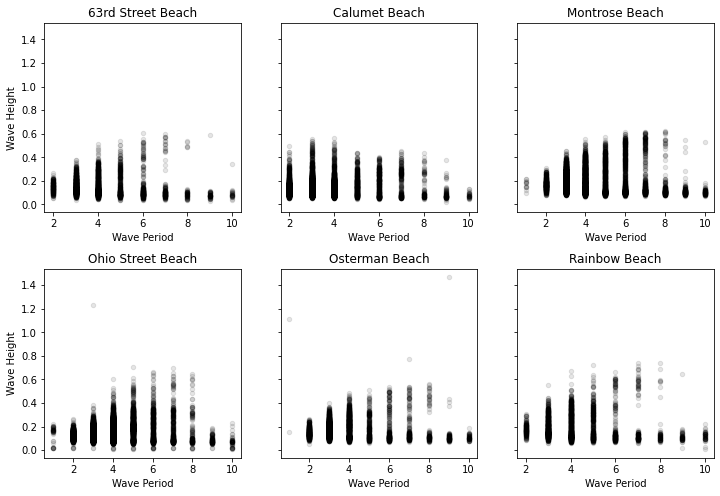

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace=0.3)
axes = list(axes.reshape(-1))
for b in beach_names:
    ax = axes.pop(0)
    ax.set_title(b)
    beach_df = df[df["Beach Name"] == b]
    beach_df.plot.scatter(x="Wave Period", y="Wave Height", color="k", alpha=0.1, ax=ax)

# Observation: beaches have distinct patterns (use OneHot encoding)

### Four Models

1. wave period (linear)
2. wave period (polynomial)
3. beach
4. beach and wave period

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer

In [19]:
train_df, test_df = train_test_split(df)
len(train_df), len(test_df)

(29871, 9958)

###### linear

In [23]:
m1 = LinearRegression()
m1.fit(train_df[["Wave Period"]], train_df["Wave Height"])
print(m1.score(test_df[["Wave Period"]], test_df["Wave Height"]))
scores = cross_val_score(m1, train_df[["Wave Period"]], train_df["Wave Height"], cv=10)
scores.mean()

0.0030354804199819174


0.0027938067311175097

###### polynomial

In [26]:
# manually
demo = train_df[["Wave Period"]].copy()
demo["Period Squared"] = demo["Wave Period"] ** 2
demo["Period Cubed"] = demo["Wave Period"] ** 3
demo

,Wave Period,Period Squared,Period Cubed
19962,8.0,64.0,512.0
2283,4.0,16.0,64.0
33720,3.0,9.0,27.0
17385,4.0,16.0,64.0
3674,5.0,25.0,125.0
...,...,...,...
15334,3.0,9.0,27.0
10044,4.0,16.0,64.0
30138,3.0,9.0,27.0
29016,3.0,9.0,27.0


In [33]:
poly = PolynomialFeatures(degree=3, include_bias=False)
data = poly.fit_transform(train_df[["Wave Period"]]) # return numpy array
pd.DataFrame(data, columns=poly.get_feature_names(["Period"])) # convert into dataframe

/home/sabi/system/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Period,Period^2,Period^3
0,8.0,64.0,512.0
1,4.0,16.0,64.0
2,3.0,9.0,27.0
3,4.0,16.0,64.0
4,5.0,25.0,125.0
...,...,...,...
29866,3.0,9.0,27.0
29867,4.0,16.0,64.0
29868,3.0,9.0,27.0
29869,3.0,9.0,27.0


In [38]:
m2 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ('lr', LinearRegression())
])

m2.fit(train_df[["Wave Period"]], train_df["Wave Height"])
scores = cross_val_score(m2, train_df[["Wave Period"]], train_df["Wave Height"], cv=10)
scores.mean()

0.04636622127765907

###### beach

In [41]:
train_df[["Beach Name"]]

,Beach Name
19962,Montrose Beach
2283,Ohio Street Beach
33720,Osterman Beach
17385,Montrose Beach
3674,63rd Street Beach
...,...
15334,Montrose Beach
10044,Calumet Beach
30138,Ohio Street Beach
29016,Ohio Street Beach


In [43]:
oh = OneHotEncoder()
data = oh.fit_transform(train_df[["Beach Name"]])
pd.DataFrame(data.toarray(), columns=oh.get_feature_names(["Beach"]))

/home/sabi/system/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Beach_63rd Street Beach,Beach_Calumet Beach,Beach_Montrose Beach,Beach_Ohio Street Beach,Beach_Osterman Beach,Beach_Rainbow Beach
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
29866,0.0,0.0,1.0,0.0,0.0,0.0
29867,0.0,1.0,0.0,0.0,0.0,0.0
29868,0.0,0.0,0.0,1.0,0.0,0.0
29869,0.0,0.0,0.0,1.0,0.0,0.0


In [51]:
m3 = Pipeline([
    ("oh", OneHotEncoder()),
    ('lr', LinearRegression())
])

scores = cross_val_score(m3, train_df[["Wave Period"]], train_df["Wave Height"], cv=10)
scores.mean()

0.04777846946086102

###### beach and wave period

In [52]:
m4 = Pipeline([
    ("both", make_column_transformer((OneHotEncoder(), ["Beach Name"]), (PolynomialFeatures(degree=2, include_bias=False), ["Wave Period"]))),
    ('lr', LinearRegression())
])

scores = cross_val_score(m4, train_df[["Beach Name", "Wave Period"]], train_df["Wave Height"], cv=10)
scores.mean()

0.08510588041595953

In [55]:
m4.fit(train_df[["Beach Name", "Wave Period"]], train_df["Wave Height"])
m4.score(test_df[["Beach Name", "Wave Period"]], test_df["Wave Height"])

0.09525903345771669